In [23]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from pprint import pprint
import copy


# Load the provided files
stock_file_path = './stock_0.csv'
classified_products_file_path = './classified_products.csv'

stock_df = pd.read_csv(stock_file_path)
classified_products_df = pd.read_csv(classified_products_file_path)

# Display the structure of the files to ensure we understand their contents
stock_df.head(), classified_products_df.head()

(   product_id  quantity expiry_date  shelf_life  time_in_stock
 0           1        21  2025-02-28          47             13
 1           2        15  2025-05-13         121             20
 2           3        25  2025-05-02         110              8
 3           4        26  2025-06-17         156              0
 4           5        23  2025-08-29         229             16,
          Product_Name        Brand    Category Usage_Frequency  Price_USD  \
 0      Magic Eyeliner     Shiseido    CC Cream          Weekly     149.16   
 1   Perfect Lip Liner  Huda Beauty   Lip Gloss          Weekly      62.28   
 2  Divine Highlighter     Bourjois     Mascara      Occasional      51.65   
 3   Ultra Highlighter     Shiseido      Primer           Daily      71.25   
 4     Ultra Lip Gloss      Kiehl’s  Eye Shadow          Weekly      78.36   
 
    Rating  Number_of_Reviews Product_Size  Skin_Type Gender_Target  \
 0     4.4               6158         50ml  Sensitive        Female   
 1 

In [24]:
# Initialize parameters and data structures
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
current_date = start_date

# Merge stock with product details for easier reference
products = pd.merge(stock_df, classified_products_df, left_on='product_id', right_on='id')

# Create the updated stock dictionary to handle multiple batches per product
initial_stock = {}

for _, row in stock_df.iterrows():
    product_id = row['product_id']
    batch = {
        'quantity': row['quantity'],
        'expiry_date': datetime.strptime(row['expiry_date'], '%Y-%m-%d')
    }
    if product_id not in initial_stock:
        initial_stock[product_id] = []
    initial_stock[product_id].append(batch)

stock = copy.deepcopy(initial_stock)

# Display the updated stock dictionary
#pprint(stock)


sales_data = []  # To store sales records
unsold_products = {}  # To store unsold products and their details

# Helper function for restocking
def restock(stock, initial_stock, current_date):

    print('RESTORIIIIINGGG!!!')

    for product_id, batches in stock.items():
        # Calcular la cantidad inicial requerida sumando los lotes
        initial_quantity = sum(batch['quantity'] for batch in initial_stock.get(product_id, []))
        
        # Calcular la cantidad actual disponible sumando los lotes existentes
        current_quantity = sum(batch['quantity'] for batch in batches)
        
        # Determinar la cantidad faltante para llegar al stock inicial
        missing_quantity = initial_quantity - current_quantity
        
        if missing_quantity > 0:
            # Crear un nuevo batch para reponer el stock faltante
            new_batch = {
                'quantity': missing_quantity,
                'expiry_date': current_date + timedelta(days=random.randint(180, 240))
            }
            # Agregar el nuevo batch al stock del producto
            stock[product_id].append(new_batch)


# Factores de ajuste
def get_adjustment_factor(current_date):
    # Factores por mes
    monthly_demand_factor = {
        1: 1.5,  # Enero
        7: 1.2,  # Julio
        8: 1.2,  # Agosto
        12: 1.5, # Diciembre
    }

    # Otros meses tienen un factor estándar
    month_factor = monthly_demand_factor.get(current_date.month, 1.0)

    # Ajustes por día del mes (principios de mes)
    if current_date.day <= 7:
        day_factor = 1.5
    else:
        day_factor = 1.0

    # Ajustes por día de la semana (fines de semana)
    if current_date.weekday() in [5, 6]:  # Sábado y domingo
        weekend_factor = 2.0
    else:
        weekend_factor = 1.0

    # Factor final
    return month_factor * day_factor * weekend_factor


# Simulate daily sales
while current_date <= end_date:
    month = current_date.month
    
    # Base sales adjusted by month and day factors
    base_sales = random.randint(0, 8)
    adjustment_factor = get_adjustment_factor(current_date)
    daily_sales_count = int(base_sales * adjustment_factor)
    
    daily_sales = []
    total_items_sold = 0

    # Al inicio del día:
    # Verificar productos caducados
    for product_id, batches in stock.items():
        expired_batches = [batch for batch in batches if batch['expiry_date'] <= current_date]
        if expired_batches:
            # Registrar los lotes caducados en `unsold_products`
            if product_id not in unsold_products:
                unsold_products[product_id] = []
            unsold_products[product_id].extend(expired_batches)
            
            # Eliminar los lotes caducados del stock
            stock[product_id] = [batch for batch in batches if batch['expiry_date'] > current_date]

    # Reabastecer si es el primer lunes del mes
    if current_date.weekday() == 0 and current_date.day <= 7:
        restock(stock, initial_stock, current_date)

    
    
    while total_items_sold < daily_sales_count:
        
        # Extract available products [6,8,28,23,1,14,...]
        available_products = [p for p in stock if any(batch['quantity'] > 0 for batch in stock[p])]
        """ print('Available products: ', available_products) """

    
        # Si no hay productos en el almacén
        if not available_products:
            raise ValueError("ALMACÉN VACÍO!!!!!")
            break
        
        # Select a product based on rotation type and stock availability
        product_id = random.choice(available_products)
        product_details = products[products['product_id'] == product_id].iloc[0]
        """ pprint(product_id)
        pprint(product_details) """

        # Determinar la cantidad máxima que se puede vender según la rotación
        rotation = product_details['Rotation']
        max_quantity = {'High': 8, 'Medium': 3, 'Low': 1}[rotation]

        # Inicializar la cantidad vendida
        sold_quantity = 0
        remaining_quantity = max_quantity

        # Ordenar los lotes por fecha de caducidad
        batches = sorted(stock[product_id], key=lambda batch: batch['expiry_date'])
        """ print('STOCK AND BATCHES')
        pprint(stock)
        pprint(batches) """

        # Procesar cada lote y vender productos
        for batch in batches:
            # Detener el bucle si no queda nada por vender o no hay stock en total
            total_stock = sum(b['quantity'] for b in batches)
            
            if remaining_quantity == 0 or total_stock == 0:
                break

            # Determinar cuánto se puede vender de este lote
            quantity_to_sell = min(batch['quantity'], remaining_quantity)
            batch['quantity'] -= quantity_to_sell
            sold_quantity += quantity_to_sell
            remaining_quantity -= quantity_to_sell

            # Registrar la venta en sales
            sales_data.append({
                'sale_id': len(sales_data) + 1,
                'product_id': product_id,
                'date': current_date,
                'quantity': quantity_to_sell,
                'total_price': quantity_to_sell * product_details['Price_USD'],
                'batch_expiry_date': batch['expiry_date']
            })
            
            total_items_sold += sold_quantity

            # Eliminar el lote del stock si su cantidad llega a 0
            if batch['quantity'] == 0:
                batches.remove(batch)

        # Actualizar el stock del producto en el diccionario principal
        stock[product_id] = batches

        # Calcular el total de ítems en el almacén
        total_items_in_stock = sum(
            batch['quantity'] for batches in stock.values() for batch in batches
        )

        print(f"Total de ítems en el almacén: {total_items_in_stock}")


        
    print(f"\nCurrent_date: {current_date}\n")
    #pprint(sales_data)
    # Move to the next day
    current_date += timedelta(days=1)

# Convert sales data to a DataFrame and save
sales_df = pd.DataFrame(sales_data)
sales_file_path = './sales.csv'
sales_df.to_csv(sales_file_path, index=False)


RESTORIIIIINGGG!!!
Total de ítems en el almacén: 427
Total de ítems en el almacén: 424

Current_date: 2024-01-01 00:00:00

Total de ítems en el almacén: 418

Current_date: 2024-01-02 00:00:00

Total de ítems en el almacén: 410
Total de ítems en el almacén: 407
Total de ítems en el almacén: 399

Current_date: 2024-01-03 00:00:00

Total de ítems en el almacén: 396
Total de ítems en el almacén: 388

Current_date: 2024-01-04 00:00:00

Total de ítems en el almacén: 385
Total de ítems en el almacén: 382
Total de ítems en el almacén: 374

Current_date: 2024-01-05 00:00:00

Total de ítems en el almacén: 373
Total de ítems en el almacén: 365
Total de ítems en el almacén: 362
Total de ítems en el almacén: 359
Total de ítems en el almacén: 351
Total de ítems en el almacén: 348
Total de ítems en el almacén: 347
Total de ítems en el almacén: 339

Current_date: 2024-01-06 00:00:00

Total de ítems en el almacén: 338
Total de ítems en el almacén: 330

Current_date: 2024-01-07 00:00:00

Total de ítems 

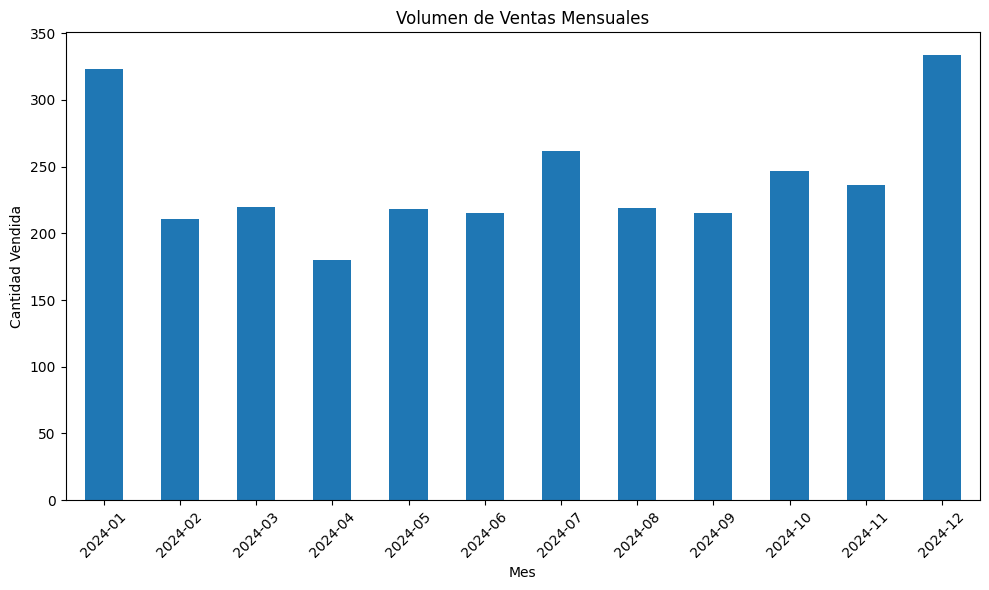

In [25]:
import matplotlib.pyplot as plt

# Asegurarnos de que la columna 'date' sea de tipo datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Calcular las ventas mensuales
monthly_sales = sales_df.groupby(sales_df['date'].dt.to_period('M'))['quantity'].sum()

# Crear la gráfica
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar')
plt.title('Volumen de Ventas Mensuales')
plt.xlabel('Mes')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


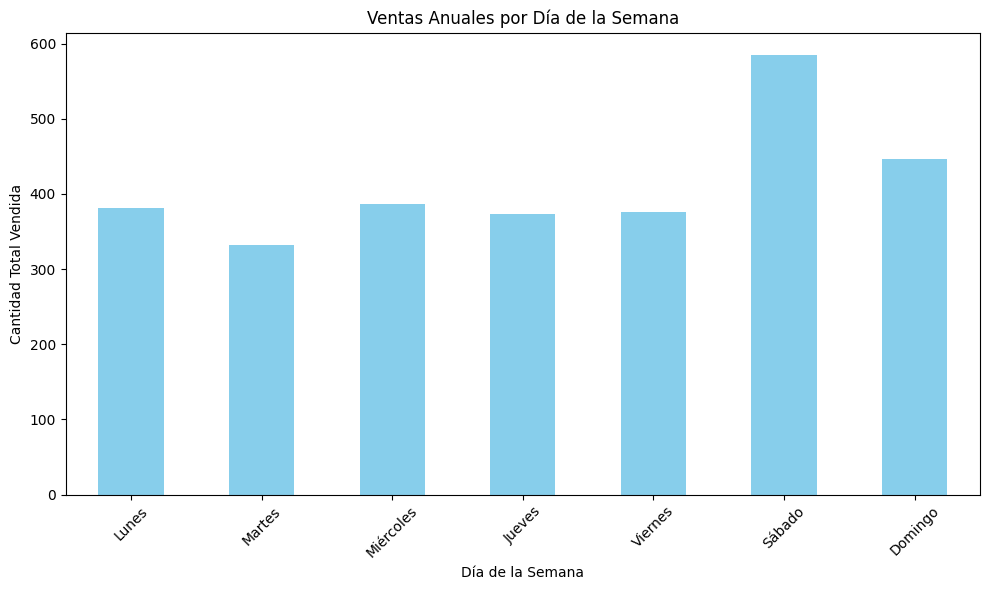

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurarte de que la columna 'date' sea de tipo datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Crear una columna con el día de la semana (lunes=0, ..., domingo=6)
sales_df['weekday'] = sales_df['date'].dt.weekday

# Agrupar por día de la semana y sumar las ventas
sales_by_weekday = sales_df.groupby('weekday')['quantity'].sum()

# Cambiar los índices a nombres de los días
sales_by_weekday.index = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Crear el gráfico
plt.figure(figsize=(10, 6))
sales_by_weekday.plot(kind='bar', color='skyblue')
plt.title('Ventas Anuales por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad Total Vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
unsold_products_list = [
    {'product_id': product_id, 'quantity': batch['quantity'], 'expiry_date': batch['expiry_date']}
    for product_id, batches in unsold_products.items()
    for batch in batches
]

print(unsold_products_list)


[]
